In [11]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.basemap import Basemap
from scipy.spatial.distance import cdist, pdist
import matplotlib.cm as cm

In [2]:
# Importing Point of Interest Data of Mumbai
df = pd.read_csv("../POI.csv")

In [3]:
df.shape

(240, 60)

In [4]:
df.head() 

,X,Y,id,@id,addr:city,addr:housenumber,addr:postcode,addr:street,building,building:levels,...,addr:state,atm,brand:wikidata,brand:wikipedia,drive_through,fax,natural,water,brand,short_name
0,73.039324,19.016573,relation/5284049,relation/5284049,Navi Mumbai,Sector 11,400614.0,Sakal Bhavan Marg,commercial,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,72.895902,19.081620,relation/5320812,relation/5320812,mumbai,NaN,400086.0,Station Road,commercial,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,72.893874,19.113860,relation/5346835,relation/5346835,Mumbai,NaN,400072.0,Chandiwali Road,commercial,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,72.818232,18.914194,way/39599369,way/39599369,Mumbai,NaN,400005.0,TL Wasvani Road,commercial,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,72.853990,19.095629,way/40772065,way/40772065,Mumabi,NaN,NaN,NaN,commercial,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Most of the columns contain null values 
# Using longitude(X) and latitute(Y) as features for spatial clustering 
new = df[['X', 'Y']].values

In [9]:
# For plotting the clusters
def plot_building_map(ax, stns):
    # determine range to print based on min, max lat and lon of the data
    lat = list(stns['Y'])
    lon = list(stns['X'])
    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    # create map using BASEMAP
    m = Basemap(llcrnrlon=lon_min,
                llcrnrlat=lat_min,
                urcrnrlon=lon_max,
                urcrnrlat=lat_max,
                lat_0=(lat_max - lat_min)/2,
                lon_0=(lon_max - lon_min)/2,
                projection='lcc',
                resolution = 'f',)

    m.drawcoastlines()
    m.fillcontinents(lake_color='aqua')
    m.drawmapboundary(fill_color='aqua')
    m.drawrivers()    
    
    # plot points
    clist = list(stns['cluster'].unique())
    if -1 in clist:
        clist.remove(-1)
    k = len(clist)
    colors = iter(cm.Set1(np.linspace(0, 1, max(10, k))))
    for i in range(k):
        color = next(colors)
        df = stns.loc[stns['cluster'] == clist[i]]        
        
        # convert lat and lon to map projection coordinates
        lons, lats = m(list(df['X']), list(df['Y']))        
        ax.scatter(lons, lats, marker = 'o', color=color, edgecolor='gray', zorder=5, alpha=1.0, s=15)


In [6]:
# K-means clustering
Ks = range(1, 10)
kmean = [KMeans(n_clusters=i).fit(new) for i in Ks]

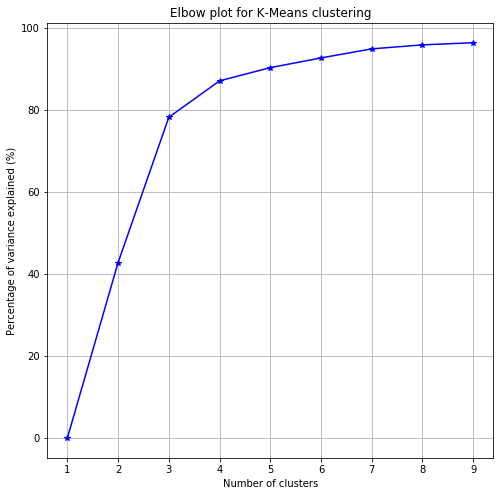

In [8]:
# Using elbow plot to find optimal number of clusters
def plot_elbow(kmean, new):
    centroids = [k.cluster_centers_ for k in kmean]
    D_k = [cdist(new, center, 'euclidean') for center in centroids]
    dist = [np.min(D,axis=1) for D in D_k]

    # Total with-in sum of square
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(new)**2)/new.shape[0]
    bss = tss-wcss

    plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    ax = plt.subplot(1, 1, 1)
    ax.plot(Ks, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained (%)')
    plt.title('Elbow plot for K-Means clustering')
    plt.show()

plot_elbow(kmean, new)

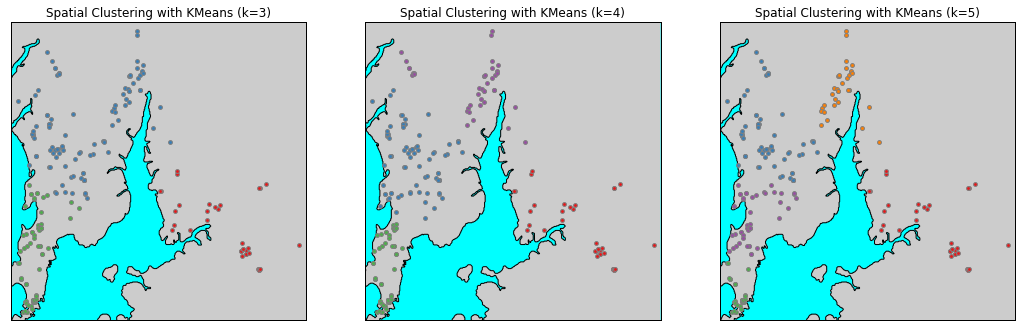

In [12]:
#From the plot, optimal no. of clusters can be 3,4 or 5.

k = [3, 4, 5]
n = len(k)
plt.subplots(nrows=1, ncols=3, figsize=(18,15))

for i in range(n):
    est = kmean[k[i]-1]
    df['cluster'] = est.predict(new).tolist()
    
    ax = plt.subplot(1, 3, i+1)
    ax.set_title("Spatial Clustering with KMeans (k={})".format(k[i]))

    plot_building_map(ax, df)

In [ ]:
# In my opinion, 5 clusters better group the commercial areas of Mumbai. But it is hard to decide the significant clusters. 
# Also, k-means clustering doesn't consider outliers or noise. So, using DBSCAN clustering to overcome the drawbacks of k-means.

In [14]:
# Considering only desired features for DBSCAN clustering
city_df= df[["X","Y"]]
city_df.head()

,X,Y
0,73.039324,19.016573
1,72.895902,19.081620
2,72.893874,19.113860
3,72.818232,18.914194
4,72.853990,19.095629


In [15]:
city_df= StandardScaler().fit_transform(city_df)

In [16]:
# Choosing eps = 0.3 and min samples =14 to get suitable result
dbs= DBSCAN(eps= 0.3, min_samples=14).fit(city_df)
labels= dbs.labels_
print(labels)

[-1  0  0  1  0  2  1  1  0  0  0  0  0  2  2  0  0  0  0  0  2  2  0 -1
  1  1  1  0  1  1  1 -1  2  2  0  2  3  0  0  0  0  0 -1  0  0  0  0 -1
 -1  3  3  3 -1  3  0  3  3  0  0  0  3  0  3  3  0 -1  0  0  1  1  0  1
  1  1  2  1  0  1  0  0  1 -1 -1 -1  3  4  4 -1 -1  3  3  0  1  2  0  0
  2  2 -1  0  2  2  2  1  4  2 -1  3  3  3  0  0  0  0  0  0  1  1  1  1
  1  3  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0  0  1  3  1  0  0
  3  0  2  2  2  2  0  0  2  0  2  2  2 -1  0 -1  0 -1 -1 -1  2  2  2  2
  2  4  4  4  4 -1  4  4  4  4  4  4  4  4  4  4 -1  4 -1 -1  3  3  3  3
  3  3 -1 -1 -1  3 -1 -1  1  1  1  1  2  1  2 -1  1  4  4  2  2  1  2 -1
 -1 -1  0  1  0 -1  3  3  2  2  2  2  2 -1  0 -1  3 -1  2 -1 -1 -1  0 -1]


In [17]:
# Number of clusters and noise points
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

core_samples_mask = np.zeros_like(dbs.labels_, dtype=bool)
core_samples_mask[dbs.core_sample_indices_] = True

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 5
Estimated number of noise points: 41


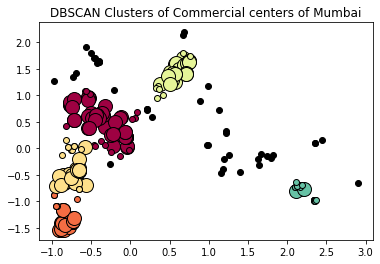

In [18]:
# Plotting the clusters formed

unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = city_df[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = city_df[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('DBSCAN Clusters of Commercial centers of Mumbai')
plt.show()

In [ ]:
# Statistically from the plot, maroon colored cluster of commercial buildings is the largest and most dense,
# and hence the most significant cluster.
# Intuitively as well, maroon cluster covers major commercial areas of Mumbai like BKC, Andheri, Powai, etc.
# so it is the most significant cluster.

# Black points represent noise in the POI data.